In [1]:
from salishsea_tools import rivertools
import netCDF4 as NC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gsw_calls

In [ ]:
#reload(rivertools)

In [2]:
#what type of file would you like to create?
#e.g. 'constant' - yearly average used for all months
#     'monthly' - monthly averages used for each month
rivertype = 'monthly'
# what type of river, Long or Short?
length = 'long'
#bathymetry
if length == 'long':
    bathyname = 'bathy_downonegrid2.nc'
else:
    bathyname = 'bathy_meter_SalishSea2.nc'

In [3]:
# set bathymetry
bathy = '../../../nemo-forcing/grid/' + bathyname
# set initialized depth (everywhere its this except where set in prop_dict files)
init_depth = 3.
# set initialized temperature (everywhere its this temperature except where reset)
# for monthly, any value other than -99 will call the rivertemp(month) to set the temperatures
init_temp = 9.

In [4]:
#get river fluxes from netcdf file
if rivertype == 'constant':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_cnst.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array(bathy=bathy, init_depth=init_depth,
                                                              init_temp=init_temp)
if rivertype == 'monthly':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_monthly.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array_monthly(bathy=bathy, 
                                                                       init_depth=init_depth,
                                                                       init_temp=init_temp)

In [5]:
print (run_depth.max(), run_temp.max())

3.0 18.7962798445


In [6]:
# make temperature conservative temperature
# this is terrible inefficient because its doing the full 898 x 398 of uniform temperatures
sal_ref = np.zeros_like(run_temp)
temp_cons = gsw_calls.call_CT_from_PT(sal_ref, run_temp)

(12, 898, 398)


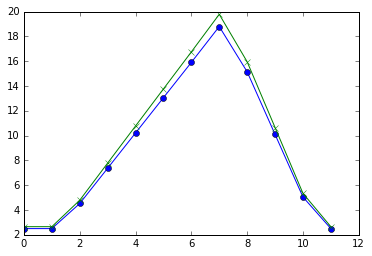

In [7]:
print (temp_cons.shape)
if rivertype == 'monthly':
    plt.plot (run_temp[:,0,0], 'o-')
    plt.plot (temp_cons[:,0,0], 'x-')
else:
    print (temp_cons[15,15])

In [8]:
#get dimensions for netcdf files
fB = NC.Dataset(bathy, 'r')
lat = fB.variables['nav_lat']
lon = fB.variables['nav_lon']
D = fB.variables['Bathymetry'][:]
ymax, xmax = D.shape
print (lat[:].shape)

(898, 398)


In [9]:
# make temperature file
nemo = NC.Dataset('river_ConsTemp_month.nc', 'w')
nemo.description = 'Monthly Average Temperature, Conservative Temperature' 

# dimensions
nemo.createDimension('x', xmax)
nemo.createDimension('y', ymax)
nemo.createDimension('time_counter', None)
    
# variables
# latitude and longitude
nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
nav_lat = lat
    
nav_lon = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
nav_lon = lon

# time
time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
time_counter.units = 'non-dim'
time_counter[0:12] = range(1,13)

# temperature
rotemper = nemo.createVariable('rotemper','float32',('time_counter','y','x'),zlib=True)
rotemper._Fillvalue = -99.
rotemper.missing_value = -99.
rotemper.units = 'deg C'
rotemper.longname = 'Conservative Temperature'
rotemper[0:12,:] = temp_cons
    
nemo.close()

In [ ]:
#list of watersheds we are including
names = ['skagit', 'fraser', 'evi_n', 'howe', 'bute', 'puget', 'jdf', 'evi_s', 'jervis', 'toba']

In [ ]:
for name in range(0,len(names)):
    watershedname = names[name]
    Flux = fluxfile.variables[watershedname][:]
    if rivertype == 'constant':
        Flux = float(Flux)
    runoff_orig = np.copy(runoff)
    runoff, run_depth, run_temp = rivertools.put_watershed_into_runoff(rivertype,
                                            watershedname, Flux, runoff, run_depth, temp_cons,
                                            Fraser_River=length)
    if rivertype == 'constant':
        rivertools.check_sum(runoff_orig, runoff, Flux)
    if rivertype == 'monthly':
        rivertools.check_sum_monthly(runoff_orig, runoff, Flux)

In [ ]:
print (run_depth.max(), temp_cons.max())
if rivertype=='monthly':
    plt.plot(temp_cons[:,351,345])
    print (np.mean(temp_cons[:,351,345]))

In [ ]:
if rivertype == 'constant':
    
    if length == 'short':
        nemo = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst.nc', 'w')
        nemo.description = 'Constant Yearly Average, All Rivers, Short Fraser' 
    elif length == 'long':
        nemo = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst_extended.nc', 'w')
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0] = 1
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff._Fillvalue = 0.
    rorunoff._missing_value = 0.
    rorunoff._units = 'kg m-2 s-1'
    rorunoff[0,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth._Fillvalue = -1.
    rodepth.missing_value = -1.
    rodepth.units = 'm'
    rodepth[:] = run_depth
    nemo.close()

In [ ]:
print (runoff.shape)
print (temp_cons.shape)
print (rivertype, length)

In [ ]:
if rivertype == 'monthly':
    if length == 'short':
        nemo = NC.Dataset('rivers_month.nc', 'w')
        nemo.description = 'Monthly Averages, All Rivers, Short Fraser' 
    elif length == 'long':
        nemo = NC.Dataset('rivers_month_extended_CT.nc', 'w')
        nemo.description = 'Monthly Averages, All Rivers, Long Fraser'
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0:12] = range(1,13)
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff._Fillvalue = 0.
    rorunoff._missing_value = 0.
    rorunoff._units = 'kg m-2 s-1'
    rorunoff[0:12,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth._Fillvalue = -1.
    rodepth.missing_value = -1.
    rodepth.units = 'm'
    rodepth[:] = run_depth[0,:,:]
    # temperature
    rotemper = nemo.createVariable('rotemper','float32',('time_counter','y','x'),zlib=True)
    rotemper._Fillvalue = -99.
    rotemper.missing_value = -99.
    rotemper.units = 'deg C'
    rotemper.longname = 'Conservative Temperature'
    rotemper[0:12,:] = temp_cons
    nemo.close()

In [ ]:
%matplotlib inline

test = NC.Dataset('rivers_month_extended_CT.nc','r')
test2 = NC.Dataset('../../../NEMO-forcing/rivers/rivers_month.nc', 'r')
plotting = test.variables['rorunoff'][0, :, :]
plot2 = test2.variables['rorunoff'][0, :, :]

plt.figure(figsize=(19, 19))
plt.pcolormesh(lon[:], lat[:], D, cmap='cool')
for i in range(0,898):
    for j in range(0,398):
        if plotting[i,j] > 0:
            plt.plot(lon[i,j],lat[i,j],'m*')
        if plot2[i, j] > 0:
            plt.plot(lon[i,j], lat[i,j], 'yo')
plt.colorbar()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Location of rivers included, with depth contours [m]')
plt.savefig('river_locations.pdf')


In [ ]:
temp = test2.variables['rotemper'][:]
roro = test2.variables['rorunoff'][:]
print (temp.shape)
plt.plot(temp[:,351,345])
print (temp.max())

In [ ]:
if rivertype == 'monthly':
    depths = D[roro[0] > 0.]
    ii, jj = np.where(roro[0] > 0.)
elif rivertype == 'constant':
    depths = D[roro > 0.]
    ii, jj = np.where(roro > 0.)

In [ ]:
print (ii[depths.mask], jj[depths.mask])
ip = ii[depths.mask]; jp = jj[depths.mask]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(D)
ax.plot(jp[0], ip[0],'mo')
ax.set_xlim((35, 65))
ax.set_ylim((870, 898))
ax.plot(45+0.5, 891+0.5,'r*')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(D)
ax.plot(jp[:3], ip[:3],'mo')
ax.set_xlim((300, 320))
ax.set_ylim((635, 655))
ax.plot(307+0.5, 651+0.5,'r*')
ax.plot(309+0.5, 650+0.5,'r*')
ax.plot(310+0.5, 649+0.5,'r*')

In [ ]:
test.close()
nemo.close()